# 1. Fitting models to data

In [222]:
import math

In [223]:
import numpy as np
import pandas as pd

In [224]:
import matplotlib
import matplotlib.pyplot as plt

In [225]:
%matplotlib inline

In [226]:
import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf

#fix error in some versions of statsmodels
import scipy
if not hasattr(scipy.stats, 'chisqprob'):
    scipy.stats.chisqprob = lambda chisq, df: scipy.stats.chi2.sf(chisq, df)

In [227]:
import pymc3 as pm

In [228]:
gapminder = pd.read_csv('Exercise Files/gapminder.csv')

In [229]:
gdata = gapminder.query('year == 1985') #filter by year

In [230]:
size = 1e-6 * gdata.population

colors = gdata.region.map({'Africa': 'skyblue', 'Europe':'gold', 'America':'palegreen', 'Asia':'coral'})

#create function because it will be used multiple times
def plotdata():
    gdata.plot.scatter('age5_surviving', 'babies_per_woman',
                      c=colors, s=size, linewidth=0.5, edgecolor='k', alpha=0.5)

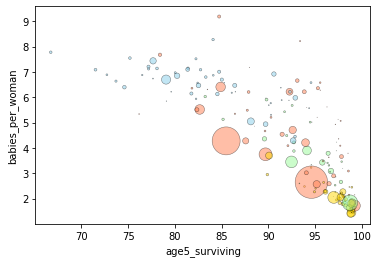

In [231]:
plotdata()

In [232]:
#ordinary least squares method from statsmodels
model = smf.ols(formula='babies_per_woman ~ 1', data=gdata) #~1 means constant of 1

In [233]:
grandmean = model.fit()

In [234]:
grandmean

In [235]:
#create function because it will be used a lot
def plotfit(fit):
    plotdata()
    plt.scatter(gdata.age5_surviving, fit.predict(gdata),
               c=colors, s=30, linewidth=0.5, edgecolor='k', marker='D') #'D' means diamond marker

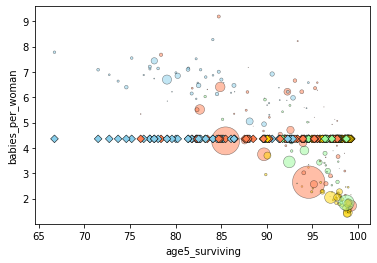

In [236]:
plotfit(grandmean) #model is basically the mean

In [237]:
grandmean.params

Intercept    4.360714
dtype: float64

In [238]:
gdata.babies_per_woman.mean() #same thing

4.360714285714285

In [239]:
#model based on regions
groupmeans = smf.ols(formula='babies_per_woman ~ 1 + region', data=gdata).fit()

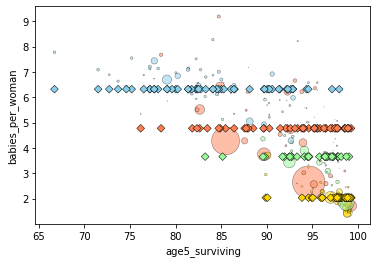

In [240]:
plotfit(groupmeans)

In [241]:
groupmeans.params #Africa's mean is used as Intercept

Intercept            6.321321
region[T.America]   -2.663139
region[T.Asia]      -1.545744
region[T.Europe]    -4.285639
dtype: float64

In [242]:
groupmeans = smf.ols(formula='babies_per_woman ~ -1 + region', data=gdata).fit() #treats all regions the same

In [243]:
groupmeans.params #Africa's mean is no longer Intercept

region[Africa]     6.321321
region[America]    3.658182
region[Asia]       4.775577
region[Europe]     2.035682
dtype: float64

In [244]:
gdata.groupby('region').babies_per_woman.mean()

region
Africa     6.321321
America    3.658182
Asia       4.775577
Europe     2.035682
Name: babies_per_woman, dtype: float64

In [245]:
#model based on age5_surviving
surviving = smf.ols(formula='babies_per_woman ~ -1 + region + age5_surviving', data=gdata).fit()

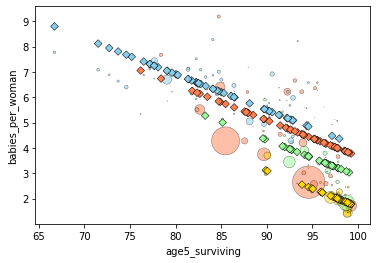

In [246]:
plotfit(surviving) #fit is improving

In [247]:
surviving.params 
#age5_surviving is the only one with a slope
#values for regions are large because they are Intercepts (corresponding to 'babies_per_woman' if 'age5_surviving' was 0)

region[Africa]     18.265792
region[America]    17.085884
region[Asia]       17.864741
region[Europe]     15.872183
age5_surviving     -0.141886
dtype: float64

In [248]:
#model based on age5_surviving and region with interaction term instead of main term (uses 2 explanatory variables)
#returns different slope per region
surviving_byregion = smf.ols(formula='babies_per_woman ~ -1 + region + age5_surviving:region', data=gdata).fit()

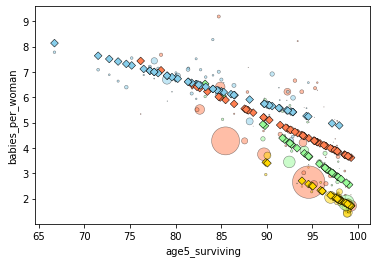

In [249]:
plotfit(surviving_byregion)

In [250]:
surviving_byregion.params

region[Africa]                    15.080914
region[America]                   27.506243
region[Asia]                      20.032483
region[Europe]                    19.884446
age5_surviving:region[Africa]     -0.104053
age5_surviving:region[America]    -0.251994
age5_surviving:region[Asia]       -0.165384
age5_surviving:region[Europe]     -0.183029
dtype: float64

In [251]:
#adding population variable because India and China seem to be outliers
surviving_byregion_population = smf.ols(formula='babies_per_woman ~ -1 + region + age5_surviving:region + population', 
                             data=gdata).fit()

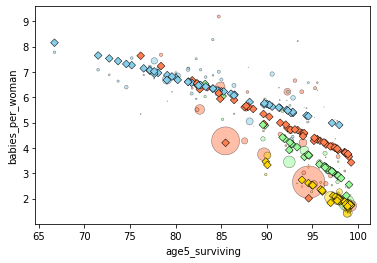

In [252]:
plotfit(surviving_byregion_population)
#model is no longer straight line due to population variable

# 2. Goodness of fit

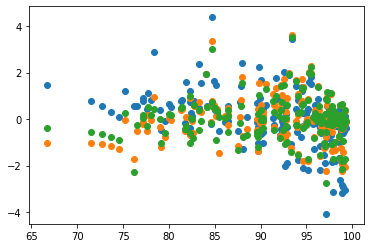

In [253]:
#scatter plot of explanatory variables against residuals
plt.scatter(gdata.age5_surviving,groupmeans.resid)
plt.scatter(gdata.age5_surviving,surviving.resid)
plt.scatter(gdata.age5_surviving,surviving_byregion_population.resid)
#most complicated model is best fit, but not by much

In [254]:
#3 measure of goodness of fit: mean squared error
for model in [groupmeans, surviving, surviving_byregion_population]:
    print(model.mse_resid)

1.4979520263709154
0.9423025333008324
0.8480227300570319


In [255]:
#R-squared
for model in [groupmeans, surviving, surviving_byregion_population]:
    print(model.rsquared)

0.636467696559659
0.7726009080146058
0.7999775707885217


In [256]:
#F statistics (determines whether more complicated model actually contributes value)
for model in [groupmeans, surviving, surviving_byregion_population]:
    print(model.fvalue)
#surviving model is best, other one is too complicated

103.88003937611687
150.34180603430977
86.4878755672519


In [257]:
surviving.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       babies_per_woman   R-squared:                       0.773
Model:                            OLS   Adj. R-squared:                  0.767
Method:                 Least Squares   F-statistic:                     150.3
Date:                Sat, 19 Sep 2020   Prob (F-statistic):           8.26e-56
Time:                        20:34:48   Log-Likelihood:                -250.30
No. Observations:                 182   AIC:                             510.6
Df Residuals:                     177   BIC:                             526.6
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
region[Africa]     18.2658      1.168     15.639      0.000      15.961      20.571
region[America]    17.0859      1.315     12.990      0.000      14.490      19.682
region[Asia]       17.8647      1.279     13.971      0.000      15.341      20.388
region[Europe]     15.8722      1.352     11.739      0.000      13.204      18.541
age5_surviving     -0.1419      0.014    -10.294      0.000      -0.169      -0.115
==============================================================================
Omnibus:                       13.021   Durbin-Watson:                   1.947
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               18.362
Skew:                           0.443   Prob(JB):                     0.000103
Kurtosis:                       4.279   Cond. No.                     3.25e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.25e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [258]:
#retrieve ANOVA table
sm.stats.anova_lm(groupmeans)
#df(region) - degrees of freedom (#of parameters)
#df(Residual) - #of data points - #of parameters
#sum_sq(region) - Sum of Squares Total
#sum_sq(Residual) - Sum of Squares of Error
#F - F-statistic
#PR(>F) - p-value
#655 is very high F-statistic

,df,sum_sq,mean_sq,F,PR(>F)
region,4.0,3927.702839,981.925710,655.512121,2.604302e-105
Residual,178.0,266.635461,1.497952,NaN,NaN


In [259]:
sm.stats.anova_lm(surviving)
#lower F-statistic for certain parameters

,df,sum_sq,mean_sq,F,PR(>F)
region,4.0,3927.702839,981.925710,1042.049316,8.236854e-122
age5_surviving,1.0,99.847912,99.847912,105.961630,9.003514e-20
Residual,177.0,166.787548,0.942303,NaN,NaN


In [260]:
sm.stats.anova_lm(surviving_byregion_population)
#even lower F-statistic for certain parameters because they are sharing interpretation

,df,sum_sq,mean_sq,F,PR(>F)
region,4.0,3927.702839,981.925710,1157.900225,1.132132e-123
age5_surviving:region,4.0,110.113541,27.528385,32.461848,3.514845e-20
population,1.0,9.813987,9.813987,11.572788,8.313090e-04
Residual,173.0,146.707932,0.848023,NaN,NaN


# 3. Cross validation

In [305]:
def sc(data):
    return 1e-6 * data.population, data.region.map({'Africa': 'skyblue', 'Europe':'gold', 
                                                    'America':'palegreen', 'Asia':'coral'})

def plotdata(data=gdata):
    size, colors = sc(data)
    data.plot.scatter('age5_surviving', 'babies_per_woman',
                     c=colors, s=size, linewidths=0.5, edgecolor='k', alpha=0.5)

def plotfit(fit, data=gdata):
    plotdata(data)
    
    size, colors = sc(data)
    plt.scatter(data.age5_surviving, fit.predict(data),
               c=colors, s=30, linewidths=0.5, edgecolor='k', marker='D')

In [262]:
#models from last section
f_groupmeans = 'babies_per_woman ~ -1 + region'
f_surviving = 'babies_per_woman ~ -1 + region + age5_surviving'
f_srp = ('babies_per_woman ~ -1 + region + age5_surviving'
        ' + age5_surviving:region - age5_surviving + population')

In [263]:
shuffled = gdata.sample(len(gdata)) #shuffled data

In [264]:
training, testing = shuffled.iloc[:len(gdata)//2], shuffled.iloc[len(gdata)//2:] #separate in half for training and testing

In [265]:
surviving = smf.ols(f_surviving, data=training).fit()

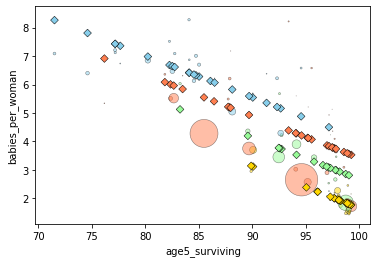

In [266]:
plotfit(surviving, training)

In [267]:
surviving.mse_resid

1.045606808874926

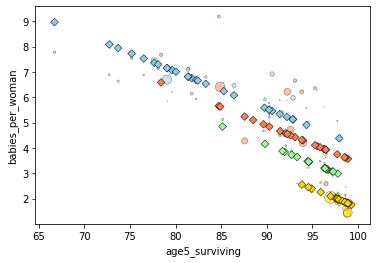

In [268]:
plotfit(surviving, testing)

In [269]:
resid = surviving.predict(testing) - testing.babies_per_woman
df = len(testing) - surviving.df_model - 1
np.sum(resid**2) / df
#margin of error higher because model has not been overfitted

0.945594396525438

In [270]:
def cross_validate(data, formula, response, n=100):
    ret = []
    
    for i in range(n):
        shuffled = data.sample(len(data))
        
        training, testing = shuffled.iloc[:len(data)//2], shuffled.iloc[len(data)//2:]
        
        trained = smf.ols(formula, data=training).fit()
        
        resid = trained.predict(testing) - testing[response]
        df = len(testing) - trained.df_model - 1
        mse = np.sum(resid**2) / df
        
        ret.append(mse)
        
    return np.mean(ret)

In [271]:
cross_validate(gdata, f_groupmeans, 'babies_per_woman')

1.6069052838420208

In [272]:
cross_validate(gdata, f_surviving, 'babies_per_woman')

1.0415243699183225

In [273]:
cross_validate(gdata, f_srp, 'babies_per_woman')
# in real world, k-fold cross-validation is used with scikit-learn

1.2670275338037513

# 4. Logistic Regression

In [274]:
smoking = pd.read_csv('Exercise Files/whickham.csv')

In [275]:
smoking = smoking[smoking.age < 65]

In [276]:
color = np.where(smoking.smoker == 'No', 'skyblue', 'coral')
#jitter moves random circles up and down so they don't all lie on top of each other
jitter = 0.05*(np.random.rand(len(smoking)) - 0.5)
def plotfit(fit):
    plt.scatter(smoking.age, smoking.outcome + jitter, c=color, linewidth=0.2, edgecolor='k', alpha=0.5)
    plt.scatter(smoking.age, fit.predict(smoking), c=color, linewidth=0.2, edgecolor='gray', marker='d')

In [277]:
smoking['outcome'] = 1*(smoking['outcome'] == 'Alive')

In [278]:
ols_group_age = smf.ols('outcome ~ smoker + age', data=smoking).fit()

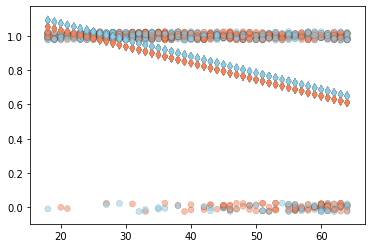

In [279]:
plotfit(ols_group_age)

In [280]:
ols_group_age.params

Intercept        1.264665
smoker[T.Yes]   -0.038738
age             -0.009615
dtype: float64

In [281]:
sm.stats.anova_lm(ols_group_age)

,df,sum_sq,mean_sq,F,PR(>F)
smoker,1.0,0.899981,0.899981,8.181417,4.314608e-03
age,1.0,17.713821,17.713821,161.030213,1.806638e-34
Residual,1068.0,117.483303,0.110003,NaN,NaN


In [282]:
ols_group_age.conf_int() #confidence intervals

,0,1
Intercept,1.198828,1.330503
smoker[T.Yes],-0.078622,0.001146
age,-0.011102,-0.008129


In [283]:
#use logistical transformation to limit variables to 0 and 1, because above 1 doesn't make any sense
#logistic transformation maps the outcome of a regular linear model to a number between 0 and 1, interpreted as the probability 
#of one of the binary outcomes
logit_smoker_age = smf.logit('outcome ~ smoker + age', data=smoking).fit()

Optimization terminated successfully.
         Current function value: 0.346766
         Iterations 7


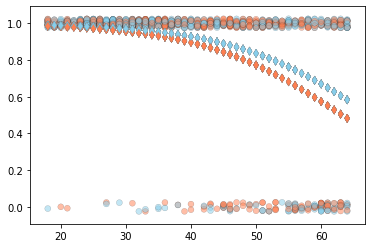

In [284]:
plotfit(logit_smoker_age)

In [285]:
logit_smoker_age.llf

-371.38650786619064

In [286]:
logit_smoker_age.params

Intercept        6.250847
smoker[T.Yes]   -0.408103
age             -0.092403
dtype: float64

In [287]:
logit_smoker_age.conf_int() #association for smoking reducing age is weak

,0,1
Intercept,5.331126,7.170568
smoker[T.Yes],-0.777754,-0.038451
age,-0.109478,-0.075327


In [288]:
logit_smoker_age.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                outcome   No. Observations:                 1071
Model:                          Logit   Df Residuals:                     1068
Method:                           MLE   Df Model:                            2
Date:                Sat, 19 Sep 2020   Pseudo R-squ.:                  0.1776
Time:                        20:34:58   Log-Likelihood:                -371.39
converged:                       True   LL-Null:                       -451.59
Covariance Type:            nonrobust   LLR p-value:                 1.469e-35
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         6.2508      0.469     13.321      0.000       5.331       7.171
smoker[T.Yes]    -0.4081      0.189     -2.164      0.030      -0.778      -0.038
age              -0.0924      0.009    -10.606      0.000      -0.109      -0.075
=================================================================================
"""

# 5. Bayesian Inference

In [289]:
#throwing an unfair coin
n = 100
k = 61 #heads

with pm.Model() as coin_context:
    p = pm.Uniform('p', 0.40, 0.80) #prior probability for heads is uniformly distributed somewhere between 0.40 and 0.80
    
    y = pm.Binomial('y', n=n, p=p, observed=k) #observed observations
    
    trace = pm.sample(10000, tune=10000, cores=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [p]


Sampling 2 chains for 10_000 tune and 10_000 draw iterations (20_000 + 20_000 draws total) took 114 seconds.


In [290]:
pm.summary(trace) #coin is most likely unfair based on mean and confidence intervals

C:\ProgramData\Anaconda3\lib\site-packages\arviz\data\io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
p,0.608,0.049,0.512,0.696,0.001,0.0,7539.0,7539.0,7525.0,11793.0,1.0


C:\ProgramData\Anaconda3\lib\site-packages\arviz\data\io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000267F1EE3388>,
      dtype=object)

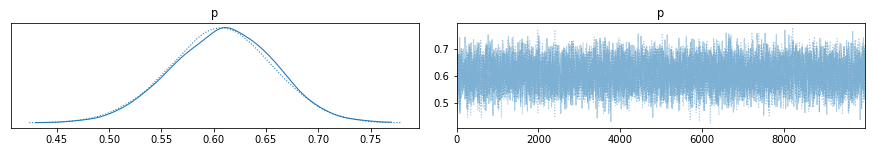

In [291]:
pm.traceplot(trace)

In [292]:
gdata = pd.read_csv('Exercise Files/gapminder.csv').query('year == 1985')

In [293]:
gdata.sort_values('age5_surviving', inplace=True)

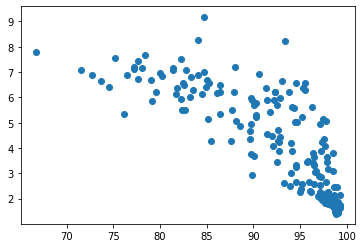

In [294]:
plt.scatter(gdata['age5_surviving'], gdata['babies_per_woman'])

In [295]:
with pm.Model() as gapminder_context:
    intercept = pm.Uniform('intercept', 5, 15) #intercept seems to be ~10, so uniform distribution between 5 and 15
    slope = pm.Uniform('slope', -1, 1) #slope seems to be somewhere between -1 and 1
    
    #each data value has random measurement error with normal distribution (simplest, most standard hypothesis)
    babies = pm.Normal('babies',
                      mu = intercept + slope * (gdata['age5_surviving'] - 65), #mu is center
                       sd = 1,
                       observed = (gdata['babies_per_woman']))
            
    trace = pm.sample(10000, tune=10000, cores=1) #Bayesian sampling

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [slope, intercept]


C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
Sampling 1 chain for 235 tune and 0 draw iterations (235 + 0 draws total) took 48 seconds.
No posterior samples. Unable to run convergence checks


In [297]:
pm.summary(trace)

ValueError: Can not extract posterior from <MultiTrace: 1 chains, 0 iterations, 4 variables>! See C:\ProgramData\Anaconda3\lib\site-packages\arviz\data\converters.py for other conversion utilities.

In [ ]:
pm.traceplot(trace) #posteriors are centered ~10 for Intercept and ~0.22 for slope

In [ ]:
babies = trace['intercept'].mean() + trace['slope'].mean() * (gdata['age5_surviving'] - 65)

In [ ]:
plt.scatter(gdata['age5_surviving'], gdata['babies_per_woman'])
plt.plot(gdata['age5_surviving'], babies, 'C1')

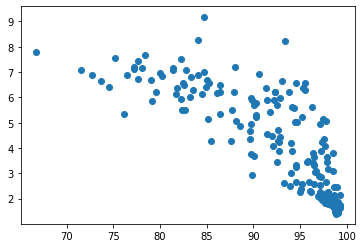

In [298]:
plt.scatter(gdata['age5_surviving'], gdata['babies_per_woman'])

#takes every 50th point, plots every different model and stops after 100 points
for i, intercept, slope in zip(range(100), trace['intercept'][::50], trace['slope'][::50]): 
    babies = intercept + slope * (gdata['age5_surviving'] - 65)
    plt.plot(gdata['age5_surviving'], babies, 'C1', alpha=0.05)
    
#every point in posterior corresponds to a different model

# 6. Challenge

In [299]:
#find even better model than "surviving" model
gdata.columns

Index(['country', 'year', 'region', 'population', 'life_expectancy',
       'age5_surviving', 'babies_per_woman', 'gdp_per_capita', 'gdp_per_day'],
      dtype='object')

In [300]:
#was told to use functions of an explanatory variable but FUCK IT LOL just added another explanatory variable
better = 'babies_per_woman ~ -1 + region + age5_surviving + life_expectancy'
cross_validate(gdata, better, 'babies_per_woman') < cross_validate(gdata, f_surviving, 'babies_per_woman')

True

0.941476767170624

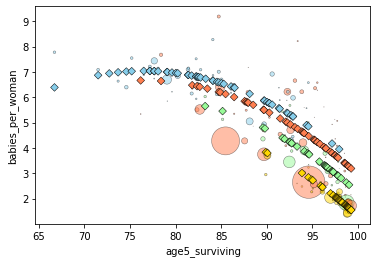

In [306]:
answer = 'babies_per_woman ~ -1 + region + age5_surviving + pow(age5_surviving, 2)' #how the fuck did he expect me to get this
fit = smf.ols(answer, gdata).fit()
plotfit(fit, gdata)
cross_validate(gdata, answer, 'babies_per_woman')